In [12]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split


In [20]:
def process_image(file_path, label=None, img_size=(100, 100), grayscale=True):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    if grayscale:
        img = tf.image.rgb_to_grayscale(img)
    img = img / 255.0  # Normalize to [0, 1]
    img = tf.squeeze(img, axis=-1)  # Remove any extra dimensions if necessary
    img = tf.expand_dims(img, axis=-1)  # Ensure the shape is (100, 100, 1)
    if label is not None:
        return img, label
    return img

def load_data(data_dir):
    if not os.path.exists(data_dir):
        raise ValueError(f"Directory {data_dir} does not exist.")
    
    file_paths = []
    labels = []
    for filename in os.listdir(data_dir):
        print(f"Processing file: {filename}")  # Debugging line
        if filename.startswith('cat'):
            label = 0
        elif filename.startswith('dog'):
            label = 1
        else:
            continue
        file_paths.append(os.path.join(data_dir, filename))
        labels.append(label)

    if not file_paths:
        raise ValueError(f"No valid files found in {data_dir}.")
    
    return file_paths, labels

def load_test_data(data_dir):
    if not os.path.exists(data_dir):
        raise ValueError(f"Directory {data_dir} does not exist.")
    
    file_paths = []
    for filename in os.listdir(data_dir):
        if filename.endswith('.jpg'):  # Update to check for .jpg files
            file_paths.append(os.path.join(data_dir, filename))
    
    if not file_paths:
        raise ValueError(f"No valid files found in {data_dir}.")
    
    return file_paths


def create_test_dataset(file_paths, batch_size=32, img_size=(100, 100), grayscale=True):
    file_paths = tf.convert_to_tensor(file_paths, dtype=tf.string)
    dataset = tf.data.Dataset.from_tensor_slices(file_paths)
    
    def _process_image(file_path):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)
        if grayscale:
            img = tf.image.rgb_to_grayscale(img)
        img = img / 255.0  # Normalize to [0, 1]
        return img

    dataset = dataset.map(_process_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

def create_dataset(file_paths, labels, batch_size=32, is_training=True, img_size=(100, 100), grayscale=True):
    file_paths = tf.convert_to_tensor(file_paths, dtype=tf.string)
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    
    def _process_image(file_path, label):
        return process_image(file_path, label, img_size, grayscale)

    dataset = dataset.map(_process_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:
        dataset = dataset.shuffle(buffer_size=len(file_paths))
        dataset = dataset.map(lambda img, lbl: (tf.image.random_flip_left_right(img), lbl), num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Load training data
train_dir = '../data/train'
train_file_paths, train_labels = load_data(train_dir)

# Split the data into training and validation sets
train_file_paths, val_file_paths, train_labels, val_labels = train_test_split(train_file_paths, train_labels, test_size=0.2, random_state=42)

# Load test data
test_dir = '../data/test'
test_file_paths = load_test_data(test_dir)

# Ensure datasets are not empty
assert len(train_file_paths) > 0, "No training data found."
assert len(val_file_paths) > 0, "No validation data found."
assert len(test_file_paths) > 0, "No test data found."

# Create Datasets
batch_size = 32
train_dataset = create_dataset(train_file_paths, train_labels, batch_size=batch_size, is_training=True)
val_dataset = create_dataset(val_file_paths, val_labels, batch_size=batch_size, is_training=False)
test_dataset = create_test_dataset(test_file_paths, batch_size=batch_size)

Processing file: cat.0.jpg
Processing file: cat.1.jpg
Processing file: cat.10.jpg
Processing file: cat.100.jpg
Processing file: cat.1000.jpg
Processing file: cat.10000.jpg
Processing file: cat.10001.jpg
Processing file: cat.10002.jpg
Processing file: cat.10003.jpg
Processing file: cat.10004.jpg
Processing file: cat.10005.jpg
Processing file: cat.10006.jpg
Processing file: cat.10007.jpg
Processing file: cat.10008.jpg
Processing file: cat.10009.jpg
Processing file: cat.1001.jpg
Processing file: cat.10010.jpg
Processing file: cat.10011.jpg
Processing file: cat.10012.jpg
Processing file: cat.10013.jpg
Processing file: cat.10014.jpg
Processing file: cat.10015.jpg
Processing file: cat.10016.jpg
Processing file: cat.10017.jpg
Processing file: cat.10018.jpg
Processing file: cat.10019.jpg
Processing file: cat.1002.jpg
Processing file: cat.10020.jpg
Processing file: cat.10021.jpg
Processing file: cat.10022.jpg
Processing file: cat.10023.jpg
Processing file: cat.10024.jpg
Processing file: cat.100

In [15]:
model = Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
# Set up callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, mode='max')

# Train the model
history = model.fit(
    train_dataset,
    epochs=150,
    batch_size=32,
    validation_data=val_dataset,
    callbacks=[checkpoint, early_stop],
    verbose=0
)

391/391 [==============================] - 6s 15ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Test Loss: 0.0000
Test Accuracy: 0.0000
391/391 [==============================] - 2s 5ms/step


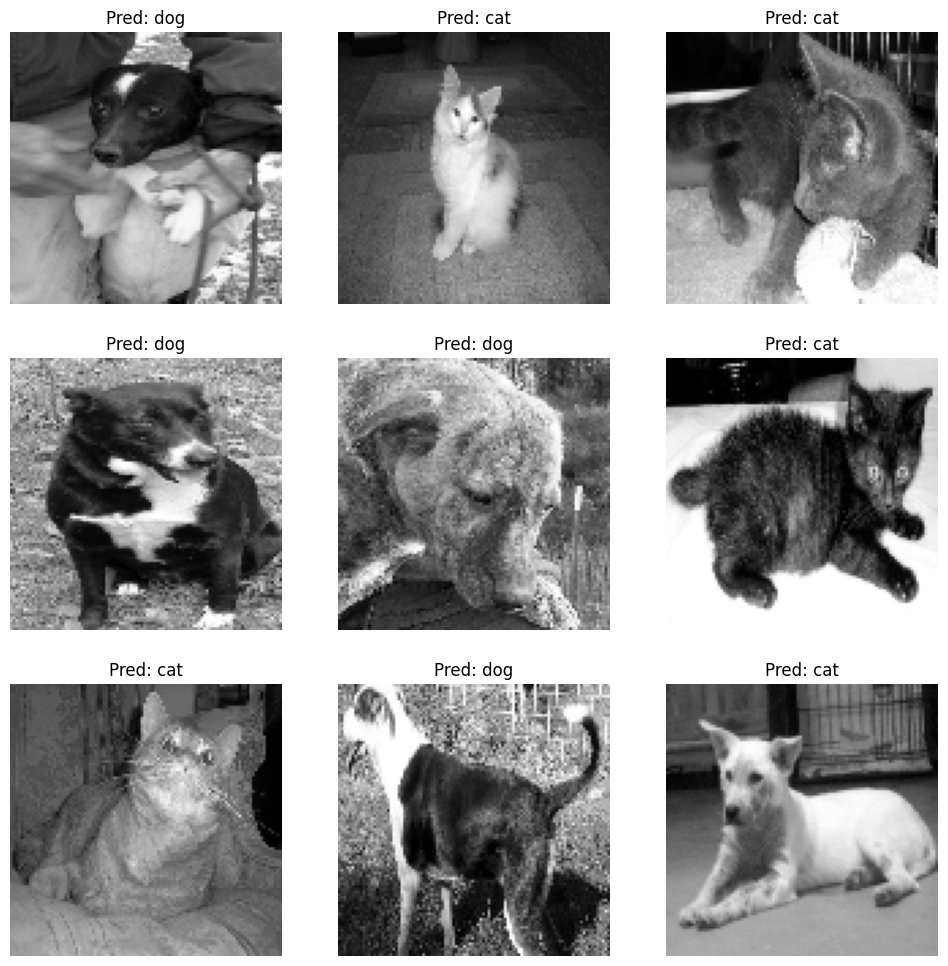

In [21]:
# Load the best model
model = load_model('best_model.h5')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Unbatch the dataset to access individual images
test_dataset = test_dataset.unbatch()

# Convert the dataset to a NumPy array
test_images = np.array([img.numpy() for img in test_dataset])

# Make predictions using the trained model
predictions = model.predict(test_images)
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Display some prediction results
def display_predictions(images, predictions, class_names):
    plt.figure(figsize=(12, 12))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')  # Show in grayscale
        plt.title(f'Pred: {class_names[predictions[i]]}')
        plt.axis('off')
    plt.show()

# Display predictions for the first batch of images
display_predictions(test_images[:9], predicted_classes[:9], ['cat', 'dog'])